# Visualizing Saliency Maps for InceptionV3 Model Predictions on ImageNet

This notebook demonstrates how to visualize saliency maps for an input image using the InceptionV3 model pre-trained on ImageNet. InceptionV3 is a deep convolutional neural network designed by Google for image classification tasks. It is part of the Inception family of models, known for their "Inception modules" which allow the network to capture multi-scale features in a single pass by performing convolutions with different filter sizes in parallel. For example, one part of the module might perform a 1x1 convolution (to capture very fine details), another part might perform a 3x3 convolution (to capture medium-sized features), and yet another part might perform a 5x5 convolution (to capture larger patterns). Additionally, pooling operations (like max-pooling) might be applied in parallel to capture even larger context. By using multiple filter sizes, the module captures a richer representation of the input image, as each filter size can detect different types of features and patterns. In addition, performing these operations in parallel within the same module allows the network to be more efficient in terms of both computation and memory usage compared to using a series of large convolutions sequentially. This architecture enables the model to better understand the context and hierarchical structure of the objects in the image.

Saliency maps highlight the parts of the image that the model focuses on when making a prediction. The key steps and components of the code are explained below:

- Importing Libraries:
 - tensorflow and tensorflow.keras for model loading, prediction, and gradient computation.
 - numpy for array manipulations.
 - matplotlib.pyplot for visualizations.
 - cv2 for image processing and applying color maps.

- Loading the Pre-trained InceptionV3 Model: The InceptionV3 model is loaded with pre-trained weights from ImageNet.
Loading and Preprocessing the Image:

- The input image is loaded and resized to 299x299 pixels. The image is converted to a numpy array and expanded to match the input shape expected by the model. The image is preprocessed using the preprocess_input function to match the format the model was trained on.

- Setting the Target Class Index: class_index is set to 250, which corresponds to the "Siberian Husky" class in ImageNet. The number of classes in ImageNet is set to 1000.

- Creating One-Hot Encoded Expected Output: The target class index is converted to a one-hot encoded vector.

- Gradient Computation: A GradientTape is used to watch the input image and compute gradients. Predictions are generated for the input image using the InceptionV3 model. The categorical cross-entropy loss is calculated between the expected output and the predictions.
Gradients of the loss with respect to the input image are computed.

- Creating the Saliency Map: The gradients are reduced to a single-channel grayscale image by summing the absolute values of the gradients across the color channels. The grayscale image is normalized to have values in the range [0, 255].

- Applying a Color Map: The grayscale saliency map is converted to a numpy array. A color map (COLORMAP_HOT) is applied to the grayscale image to enhance visibility.

- Superimposing the Saliency Map on the Original Image: The original image is normalized to have values between 0 and 1. The saliency map is superimposed on the original image using cv2.addWeighted.

- Visualizing the Results: The original image, the saliency map, and the superimposed image are displayed side by side using matplotlib.

This code was adapted from Moroney, L. and Shyu, E. Advanced Computer Vision with TensorFlow, [online] Deeplearning.ai. Available at: https://www.deeplearning.ai/.

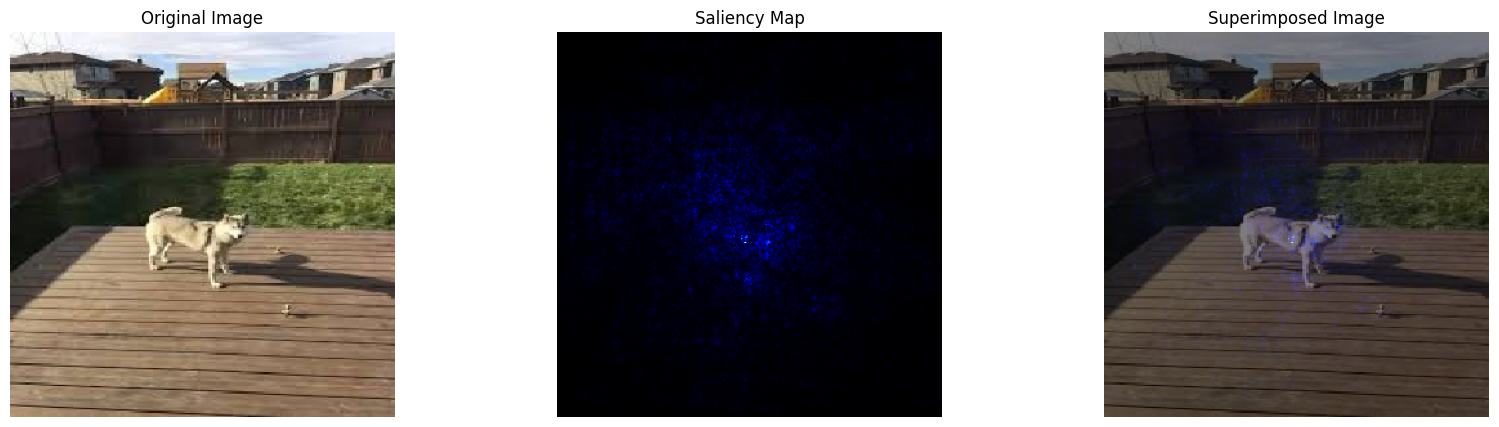

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
import cv2

# Load the InceptionV3 model
model = InceptionV3(weights='imagenet')

# Load and preprocess the image
img_path = '/content/husky_test_image.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Define the class index for Siberian Husky
class_index = 250  # Siberian Husky

# Number of classes in the model's training data
num_classes = 1000

# Convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * img_array.shape[0], num_classes)

with tf.GradientTape() as tape:
    # Cast image to float
    inputs = tf.cast(img_array, tf.float32)

    # Watch the input pixels
    tape.watch(inputs)

    # Generate the predictions
    predictions = model(inputs)

    # Get the loss
    loss = tf.keras.losses.categorical_crossentropy(expected_output, predictions)

# Get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs)

# Reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# Normalize the pixel values to be in the range [0, 255]
normalized_tensor = tf.cast(
    255 * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# Remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)

# Convert the normalized tensor to a numpy array
normalized_array = normalized_tensor.numpy()

# Apply color map to the grayscale image
gradient_color = cv2.applyColorMap(normalized_array, cv2.COLORMAP_HOT)
gradient_color = gradient_color.astype(np.float32) / 255.0

# Convert original image to float32 and normalize
img_float = (img_array[0] - img_array[0].min()) / (img_array[0].max() - img_array[0].min())

# Superimpose the gradients on the original image
super_imposed = cv2.addWeighted(img_float, 0.5, gradient_color, 0.5, 0.0)

# Visualize the input image, saliency map, and superimposed image side by side
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Display the original image
ax[0].imshow(img_float)
ax[0].axis('off')
ax[0].set_title('Original Image')

# Display the saliency map
ax[1].imshow(gradient_color)
ax[1].axis('off')
ax[1].set_title('Saliency Map')

# Display the superimposed image
ax[2].imshow(super_imposed)
ax[2].axis('off')
ax[2].set_title('Superimposed Image')

plt.show()
